# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]
drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######

# define stage
#stage = StageQuasistatic2d()
stage = StagePrtclTransWakeInstability()                      #######
stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5

# define first stage (half length)
#first_stage = StageQuasistatic2d()
first_stage = StagePrtclTransWakeInstability()                      #######
first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.005
source.bunch_length = 18e-6 # [m]
source.z_offset = -36e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
#source.num_particles = 5000
source.num_particles = 6000
source.jitter.t = driver.jitter.t

main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]

# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 0.5  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [3]:
linac.run('linac_example', num_shots=1, overwrite=True, parallel=False);

>> SHOT 1 already exists and will not be overwritten.


### Plot the wakefield

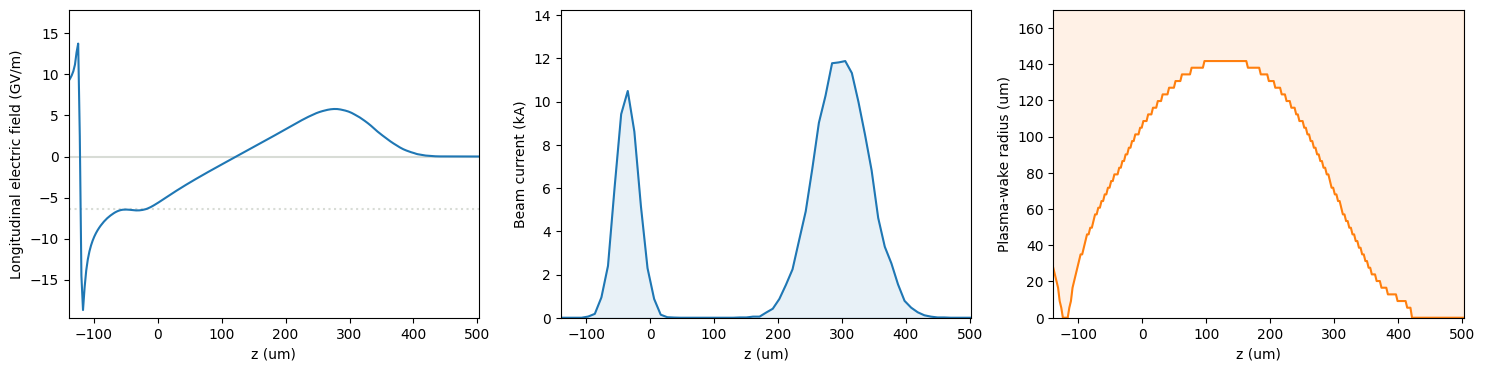

In [4]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

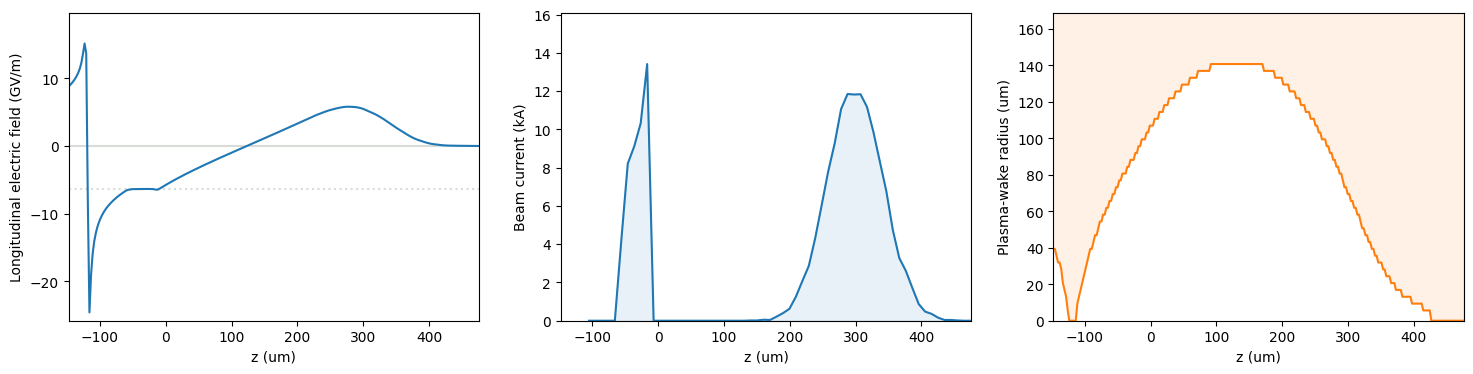

In [5]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

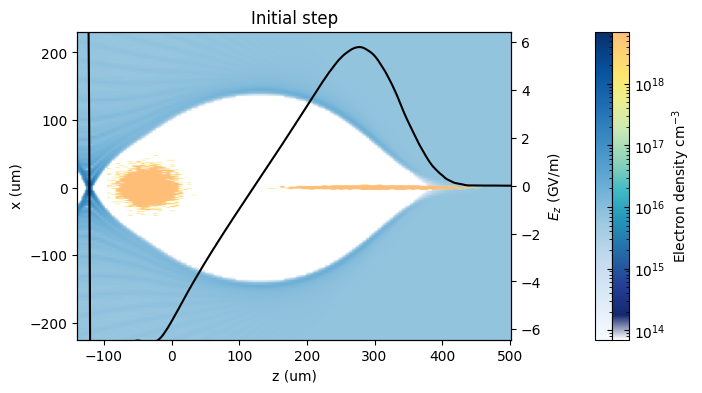

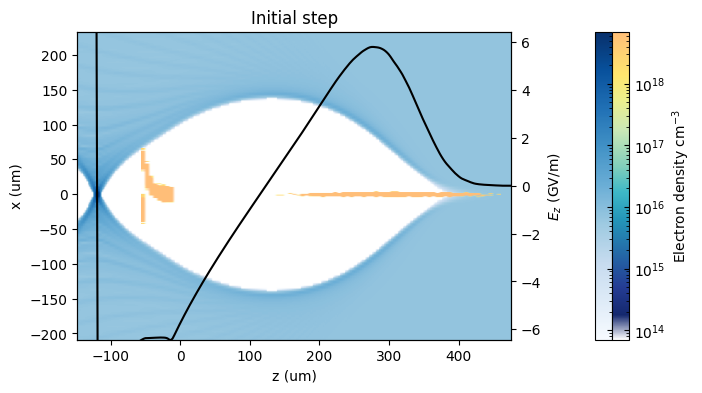

In [6]:
linac.stages[0].plot_wake()
linac.stages[-1].plot_wake()

### Plot beam evolution and survey

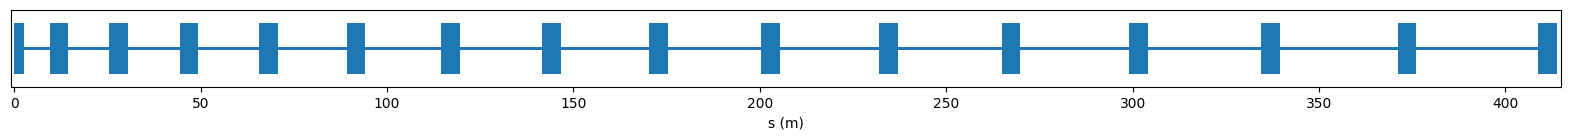

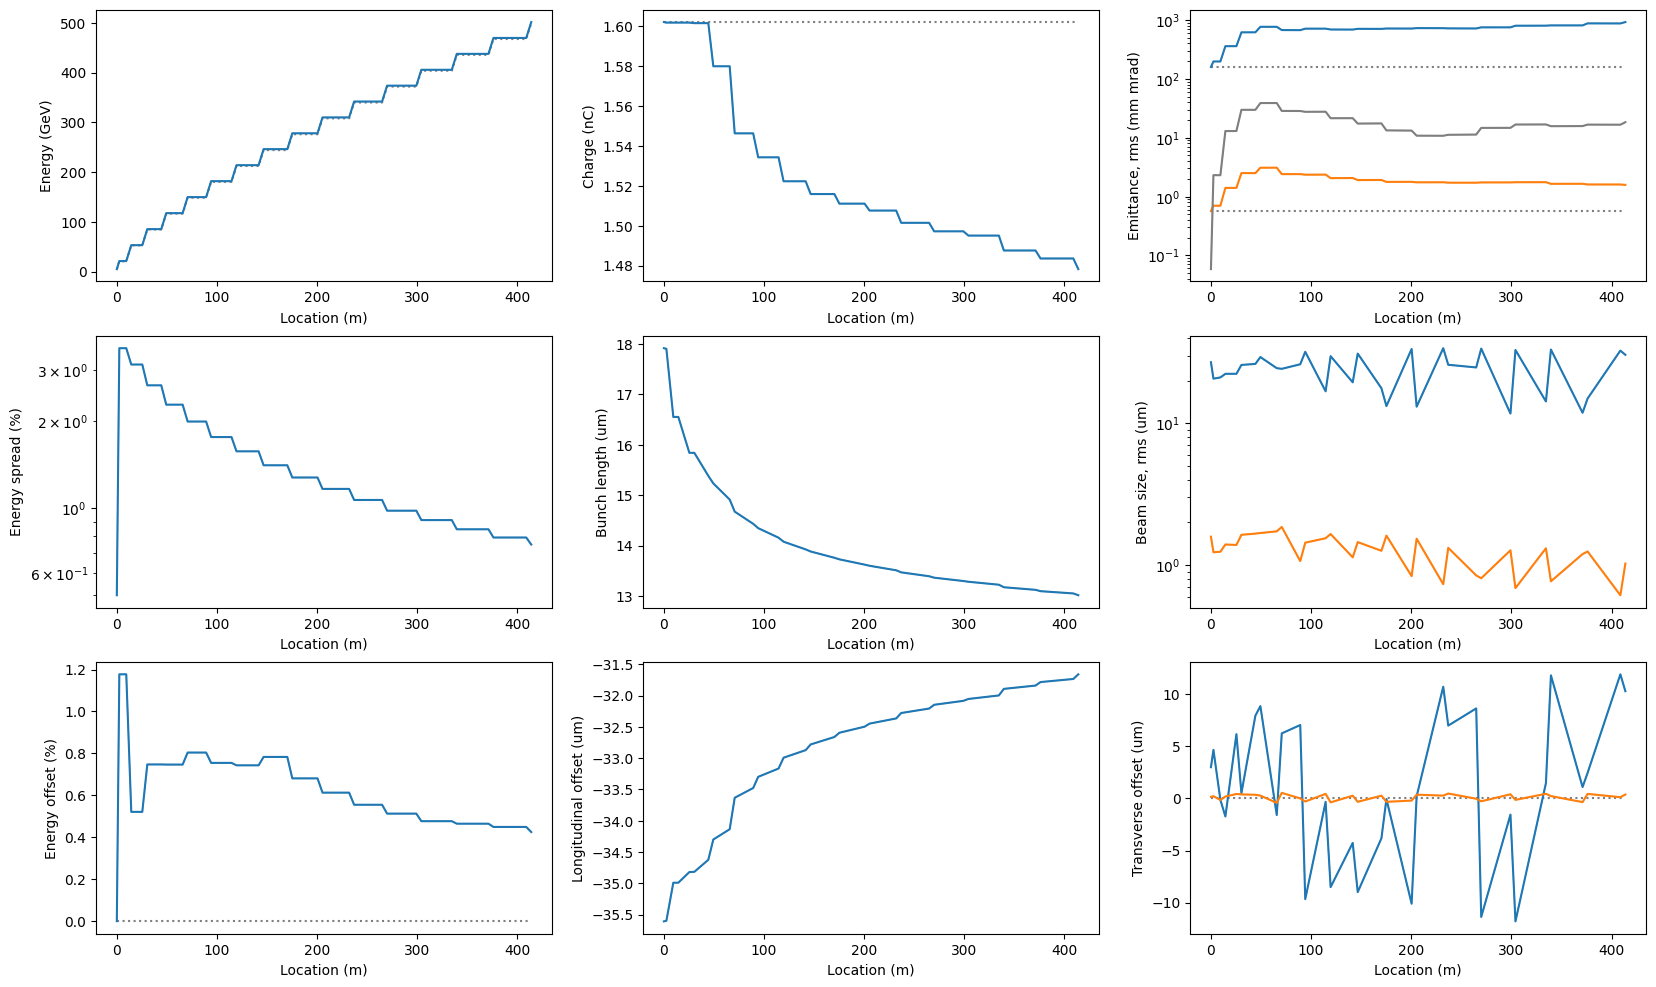

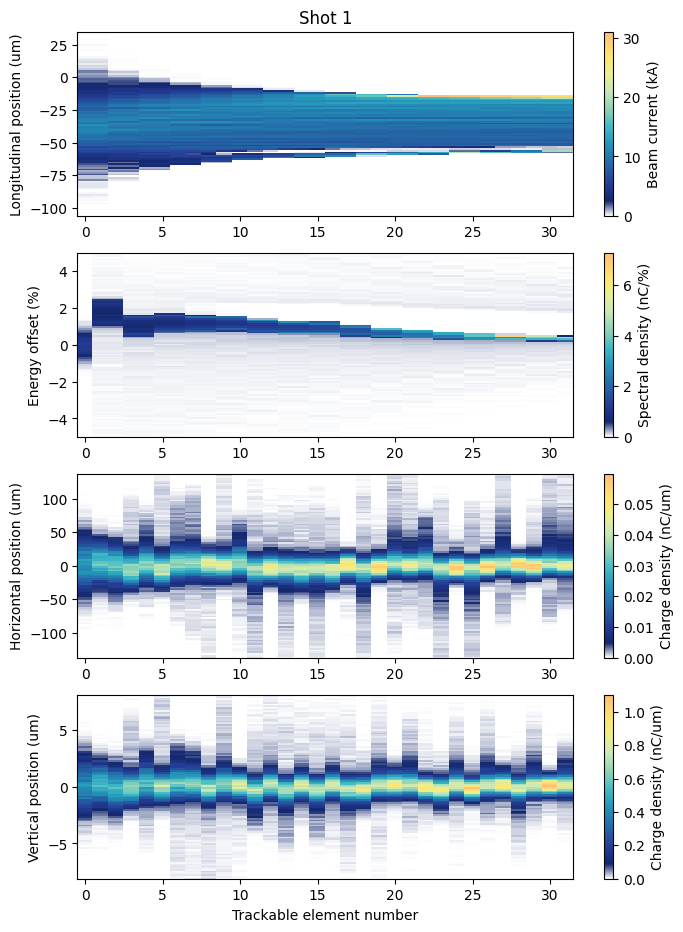

In [7]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac[0].plot_waterfalls()

In [8]:
linac.animate_lps()

'run_data/linac_example/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)

In [9]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [10]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam(), beam_out)

Time step [betatron wavelength/c]:	 0.050
Interstages enabled:			 False
Interstage dipole field:		 Not registered.
Symmetrised main beam:			 Not registered.
Symmetrised drive beam:			 False

Stage length [m]:			 5.000
Propagation length [m]:			 413.828
Plasma density [m^-3]:			 7.000e+21
Ramp beta magnification:		 5.000
Drive beam x jitter (std) [um]:		 0.000
Drive beam y jitter (std) [um]:		 0.000
---------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Initial number of macroparticles:		 10000			 6000
Current number of macroparticles:		  			 5536
Initial beam population:			 2.700e+10 		 1.000e+10
Current beam population:			 	 		 9.227e+09

Beam centre gradient [GV/m]:				  		 -6.347
Current mean gamma:				 	 		 981558.047
Initial mean energy [GeV]:			 31.252 		 5.000
Current mean 